In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageSequence

In [2]:
# Digitize function
def digitize_gif(image_path, threshold=0):
    gif = Image.open(image_path)
    spectra = []
    for frame in ImageSequence.Iterator(gif):
        frame = frame.convert('L')
        frame_array = np.array(frame)
        black_pixel_positions = np.where(frame_array <= threshold)
        y_values = [-1] * frame_array.shape[1]
        for x in range(frame_array.shape[1]):
            y_positions = black_pixel_positions[0][black_pixel_positions[1] == x]
            if len(y_positions) > 0:
                max_y_position = np.max(y_positions)
                y_values[x] = max_y_position
        spectra.append(y_values)
    return np.array(spectra)

# Data scaling function
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data), scaler  # Also returns the scaler for reuse during reconstruction

# Dataset
class SpectraDataset(Dataset):
    def __init__(self, spectra):
        self.spectra = spectra

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return torch.tensor(self.spectra[idx], dtype=torch.float32)

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_layer_sizes):
        super(VAE, self).__init__()
        # Encoder
        encoder_layers = []
        prev_size = input_dim
        for size in hidden_layer_sizes:
            encoder_layers.append(nn.Linear(prev_size, size))
            encoder_layers.append(nn.ReLU())
            prev_size = size
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_layer_sizes[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_layer_sizes[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_size = latent_dim
        for size in reversed(hidden_layer_sizes):
            decoder_layers.append(nn.Linear(prev_size, size))
            decoder_layers.append(nn.ReLU())
            prev_size = size
        decoder_layers.append(nn.Linear(hidden_layer_sizes[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for the VAE
def vae_loss(recon_x, x, mu, logvar, kl_weight=0.01):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_weight * kl_div


Epoch 1/300, Loss: 0.5741
Epoch 2/300, Loss: 0.5097
Epoch 3/300, Loss: 0.3522
Epoch 4/300, Loss: 0.2402
Epoch 5/300, Loss: 0.2233
Epoch 6/300, Loss: 0.1901
Epoch 7/300, Loss: 0.1825
Epoch 8/300, Loss: 0.1868
Epoch 9/300, Loss: 0.1781
Epoch 10/300, Loss: 0.1782
Epoch 11/300, Loss: 0.1807
Epoch 12/300, Loss: 0.1812
Epoch 13/300, Loss: 0.1826
Epoch 14/300, Loss: 0.1741
Epoch 15/300, Loss: 0.1718
Epoch 16/300, Loss: 0.1701
Epoch 17/300, Loss: 0.1676
Epoch 18/300, Loss: 0.1643
Epoch 19/300, Loss: 0.1587
Epoch 20/300, Loss: 0.1553
Epoch 21/300, Loss: 0.1493
Epoch 22/300, Loss: 0.1432
Epoch 23/300, Loss: 0.1449
Epoch 24/300, Loss: 0.1415
Epoch 25/300, Loss: 0.1384
Epoch 26/300, Loss: 0.1408
Epoch 27/300, Loss: 0.1377
Epoch 28/300, Loss: 0.1371
Epoch 29/300, Loss: 0.1379
Epoch 30/300, Loss: 0.1342
Epoch 31/300, Loss: 0.1365
Epoch 32/300, Loss: 0.1352
Epoch 33/300, Loss: 0.1357
Epoch 34/300, Loss: 0.1329
Epoch 35/300, Loss: 0.1325
Epoch 36/300, Loss: 0.1317
Epoch 37/300, Loss: 0.1330
Epoch 38/3

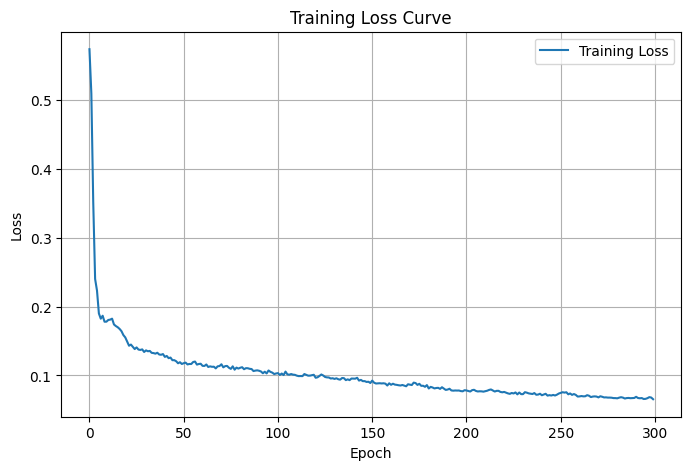

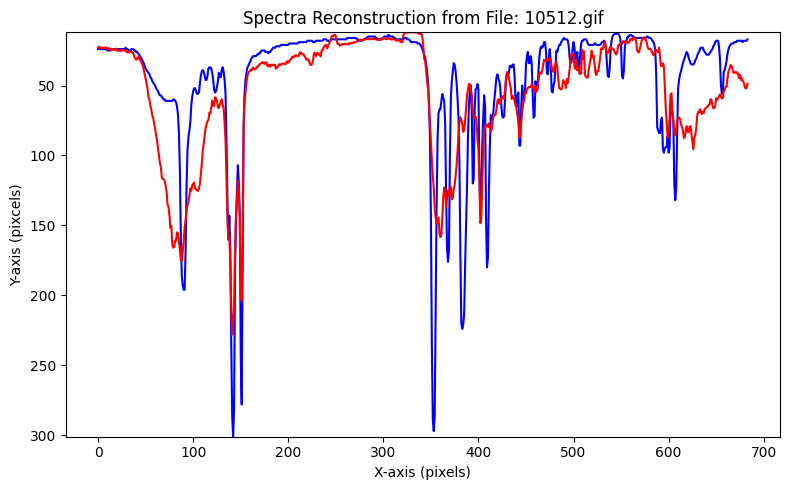

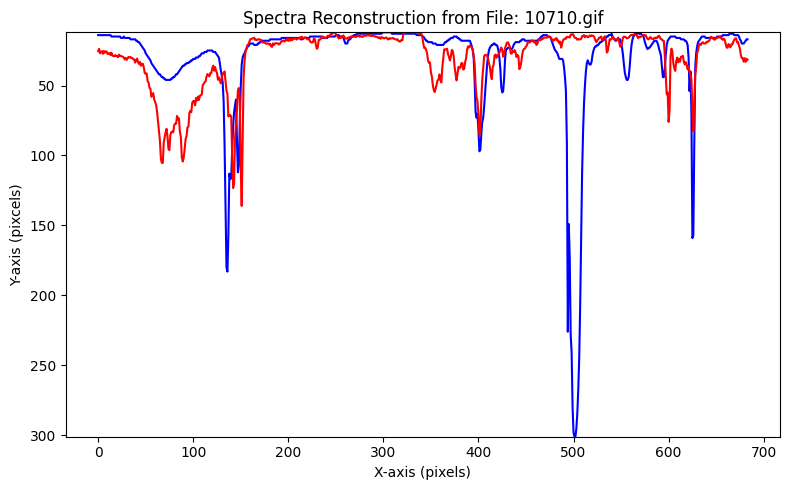

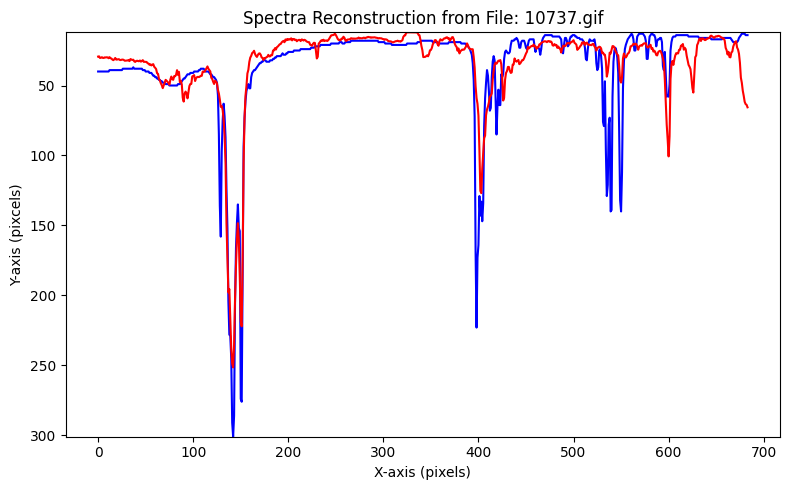

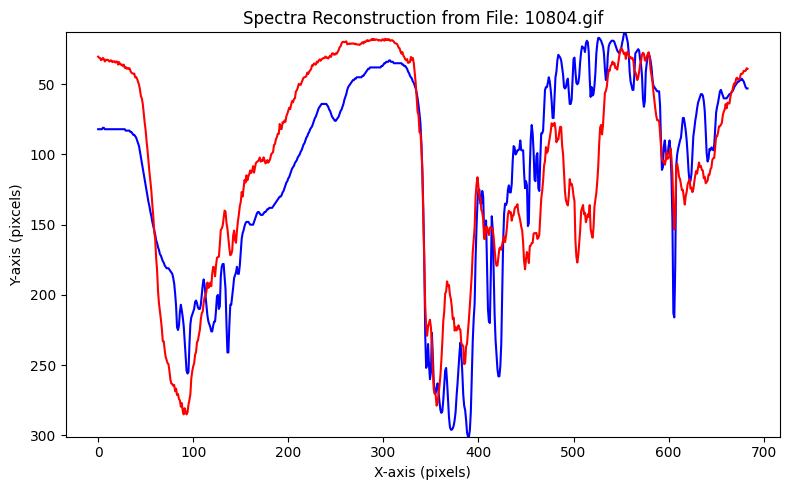

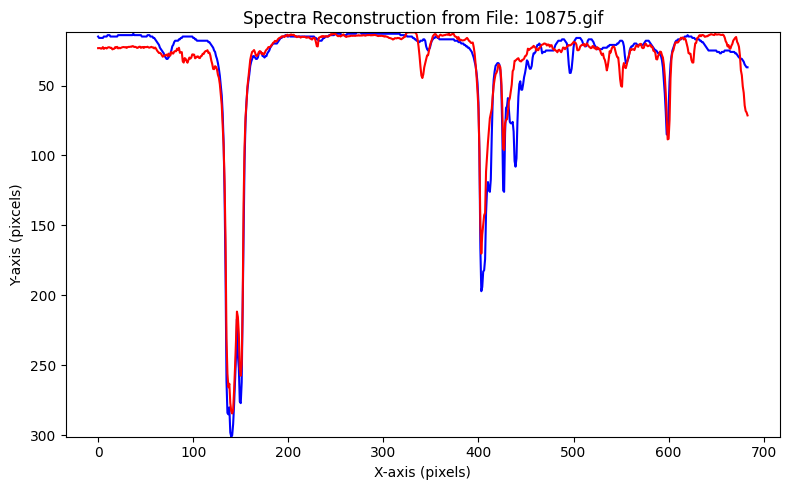

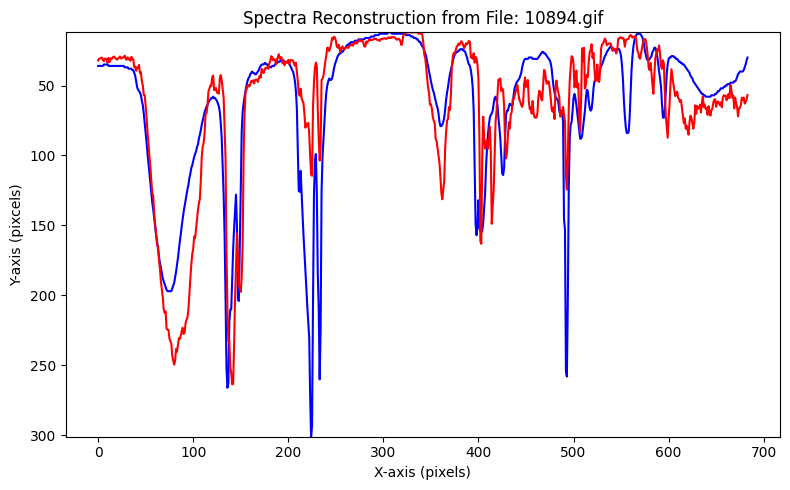

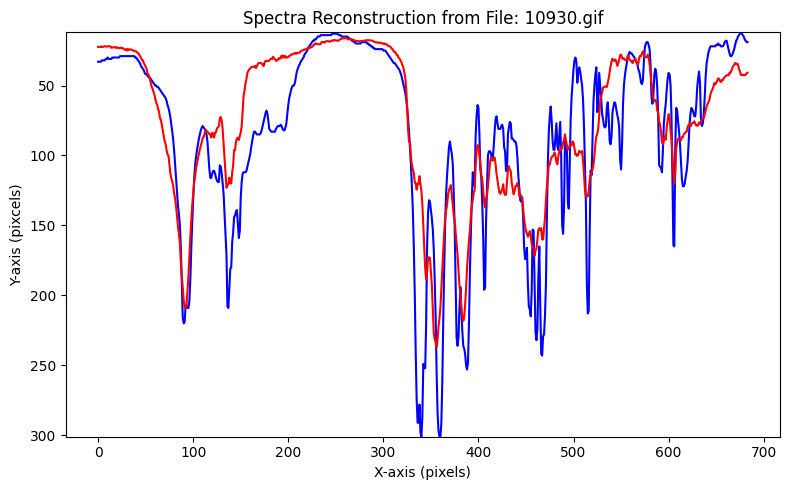

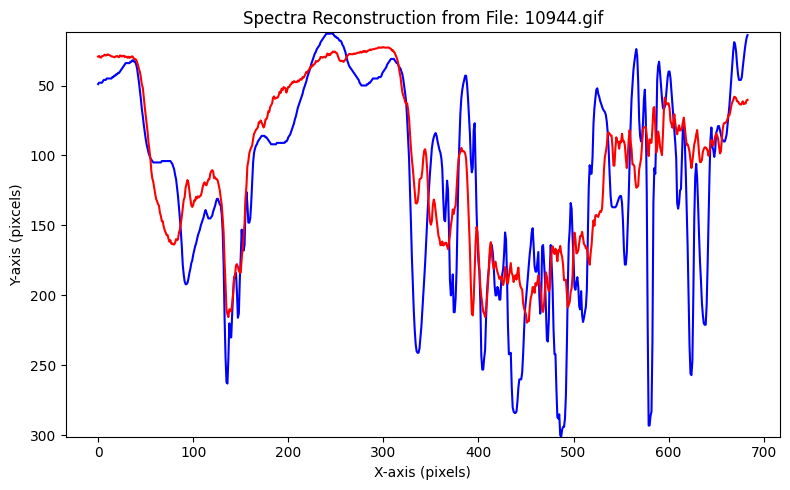

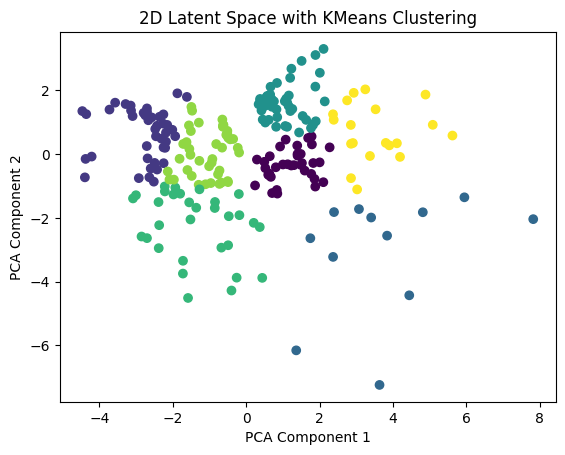

In [17]:
# Parameter settings
latent_dim = 10  # Latent dimension
hidden_layer_sizes = [512, 256, 128, 64, 32]  # Hidden layer sizes
batch_size = 64  # Batch size
epochs = 300  # Number of epochs
learning_rate = 1e-3  # Learning rate
kl_weight = 0.0001  # Weight for the KL term

# Digitize GIF images and prepare the data
image_dir = "./data/IR/cropped_images_new8/cropped_images_new8"
spectra_list = [digitize_gif(os.path.join(image_dir, f)) for f in os.listdir(image_dir) if f.endswith(".gif")]
spectra_data = np.concatenate(spectra_list, axis=0)

# Apply scaling
scaled_data, scaler = scale_data(spectra_data)

# DataLoader
dataset = SpectraDataset(scaled_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Prepare the model and optimizer
vae = VAE(input_dim=scaled_data.shape[1], latent_dim=latent_dim, hidden_layer_sizes=hidden_layer_sizes)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Training process
vae.train()
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_history.append(total_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Plot the training loss curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Verify reconstruction results (Display file name in the title & unify y-axis scale)
vae.eval()
with torch.no_grad():
    for i, file_name in enumerate(os.listdir(image_dir)):
        if not file_name.endswith(".gif"):
            continue
        
        # Get the corresponding spectrum
        spectrum = dataset[i]
        recon_spectrum, _, _ = vae(spectrum.unsqueeze(0))
        
        # Reverse scaling
        original = scaler.inverse_transform(spectrum.unsqueeze(0).numpy())
        reconstructed = scaler.inverse_transform(recon_spectrum.numpy())
        
        # Create the plot
        fig, ax1 = plt.subplots(figsize=(8, 5))
        
        # Get unified y-axis scale
        y_min = min(original.min(), reconstructed.min())
        y_max = max(original.max(), reconstructed.max())
        
        # Original spectrum (Invert y-axis & unify scale)
        ax1.plot(original.flatten(), label="Original", color="blue")
        ax1.plot(reconstructed.flatten(), label="Reconstructed", color="red")
        ax1.set_ylim(y_max, y_min)  # Invert y-axis
        ax1.set_xlabel("X-axis (pixels)")
        ax1.set_ylabel("Y-axis (pixels)")
        # ax1.tick_params(axis="y", labelcolor="blue")
        
        # Set the file name in the title
        plt.title(f"Spectra Reconstruction from File: {file_name}")
        fig.tight_layout()  # Adjust layout
        plt.show()

        # Display only the first 5 results (adjust if needed)
        if i >= 7:
            break


# Obtain latent space and reduce dimensions using PCA
latent_vectors = []
vae.eval()
with torch.no_grad():
    for batch in dataloader:
        _, mu, _ = vae(batch)
        latent_vectors.append(mu.numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)

if latent_dim > 2:
    pca = PCA(n_components=2)
    latent_vectors_2d = pca.fit_transform(latent_vectors)
else:
    latent_vectors_2d = latent_vectors

# KMeans clustering
kmeans = KMeans(n_clusters=7)  # Specify the number of clusters
labels = kmeans.fit_predict(latent_vectors_2d)

# Plot the results
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Latent Space with KMeans Clustering")
plt.show()
